In [ ]:
# import zipfile
# import os

# zip_file_path = '/content/drive/MyDrive/landslide.zip'

# extract_path = '/content/drive/My Drive/landslide_dataset'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#   zip_ref.extractall(extract_path)

# print(f"Files extracted to: {extract_path}")

In [ ]:
import os
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, concatenate, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


#Data Preparation

In [ ]:
os.chdir(r'/content/drive/MyDrive/landslide_dataset')

In [ ]:
# Testing data
single_image_path = r'/content/drive/MyDrive/landslide_dataset/TrainData/img/image_1.h5'
single_mask_path = r'/content/drive/MyDrive/landslide_dataset/TrainData/mask/mask_1.h5'

Testing dataset

ls ['img']
input data shape: (128, 128, 14)


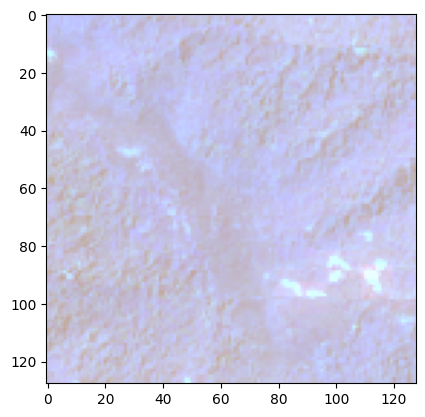

In [ ]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(single_image_path) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)

    # Display image by the reverse order based on the .h5 file
    plt.imshow(data[:, :, 3:0:-1])


    # Extract all the image channels
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]

    # Calculate NDVI - Normalized difference vegetation index
    # Đây là chỉ số để đánh giá độ phủ xanh của thực vật trên ảnh vệ tinh
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


    f_data[0, :, :, 0] = data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


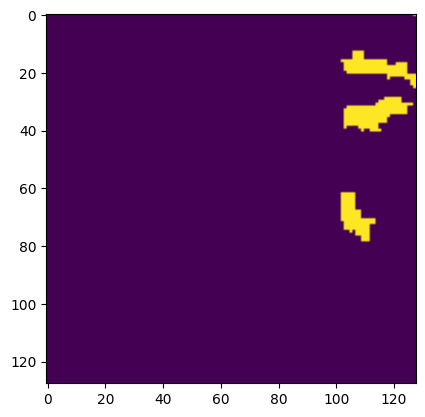

In [ ]:
with h5py.File(single_mask_path) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

Set data path

In [ ]:
train_img_path = r'/content/drive/MyDrive/landslide_dataset/TrainData/img/*.h5'
train_mask_path = r'/content/drive/MyDrive/landslide_dataset/TrainData/mask/*.h5'


In [ ]:
all_train = sorted(glob.glob(train_img_path))
all_mask = sorted(glob.glob(train_mask_path))

num_samples = len(all_train)

TRAIN_XX = np.zeros((num_samples, 128, 128, 6))
TRAIN_YY = np.zeros((num_samples, 128, 128, 1))

print(f"Found {num_samples} training images")

Found 3799 training images


Keys in HDF5 file: ['img']
Image shape: (128, 128, 14)
Red channel: min=0.9861337078574212, max=4.829584218436117
Green channel: min=0.997865047878278, max=3.539255487036551
Blue channel: min=1.0744190214147422, max=2.7381920432894895


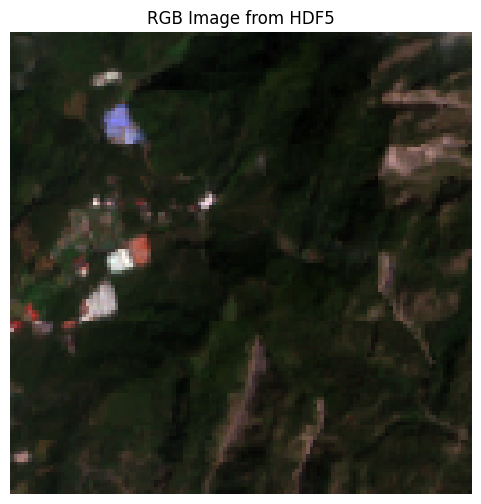

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def display_rgb_image(hdf5_path):
    """ Load an HDF5 image and display it as an RGB image. """

    with h5py.File(hdf5_path, 'r') as hdf:
        print("Keys in HDF5 file:", list(hdf.keys()))
        data = np.array(hdf.get('img'))  # Đọc ảnh từ file HDF5
        print("Image shape:", data.shape)  # Kiểm tra số lượng kênh

        # Kiểm tra nếu số kênh không đủ
        if data.shape[-1] < 4:
            print("Not enough channels in the image. At least 4 are needed (Red, Green, Blue, NIR).")
            return

        # Thay thế NaN bằng giá trị nhỏ
        data[np.isnan(data)] = 0.000001

        # Trích xuất các kênh Red, Green, Blue
        data_red = data[:, :, 3]
        data_green = data[:, :, 2]
        data_blue = data[:, :, 1]

        # Kiểm tra giá trị tối đa - tối thiểu trước khi chuẩn hóa
        print(f"Red channel: min={data_red.min()}, max={data_red.max()}")
        print(f"Green channel: min={data_green.min()}, max={data_green.max()}")
        print(f"Blue channel: min={data_blue.min()}, max={data_blue.max()}")

        # Chuyển đổi ảnh về khoảng [0, 255] (Normalize)
        def normalize_channel(channel):
            return ((channel - channel.min()) / (channel.max() - channel.min()) * 255).astype(np.uint8)

        red_norm = normalize_channel(data_red)
        green_norm = normalize_channel(data_green)
        blue_norm = normalize_channel(data_blue)

        # Gộp lại thành ảnh RGB
        rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)

        # Hiển thị ảnh
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_image)
        plt.axis("off")
        plt.title("RGB Image from HDF5")
        plt.show()

# Example usage
hdf5_path = r'/content/drive/MyDrive/landslide_dataset/TrainData/img/image_1.h5'
display_rgb_image(hdf5_path)



In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION


    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

0 /content/drive/MyDrive/landslide_dataset/TrainData/img/image_1.h5 /content/drive/MyDrive/landslide_dataset/TrainData/mask/mask_1.h5
1 /content/drive/MyDrive/landslide_dataset/TrainData/img/image_10.h5 /content/drive/MyDrive/landslide_dataset/TrainData/mask/mask_10.h5
2 /content/drive/MyDrive/landslide_dataset/TrainData/img/image_100.h5 /content/drive/MyDrive/landslide_dataset/TrainData/mask/mask_100.h5
3 /content/drive/MyDrive/landslide_dataset/TrainData/img/image_1000.h5 /content/drive/MyDrive/landslide_dataset/TrainData/mask/mask_1000.h5
4 /content/drive/MyDrive/landslide_dataset/TrainData/img/image_1001.h5 /content/drive/MyDrive/landslide_dataset/TrainData/mask/mask_1001.h5
5 /content/drive/MyDrive/landslide_dataset/TrainData/img/image_1002.h5 /content/drive/MyDrive/landslide_dataset/TrainData/mask/mask_1002.h5
6 /content/drive/MyDrive/landslide_dataset/TrainData/img/image_1003.h5 /content/drive/MyDrive/landslide_dataset/TrainData/mask/mask_1003.h5
7 /content/drive/MyDrive/landsli

KeyboardInterrupt: 

In [ ]:
# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


In [ ]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

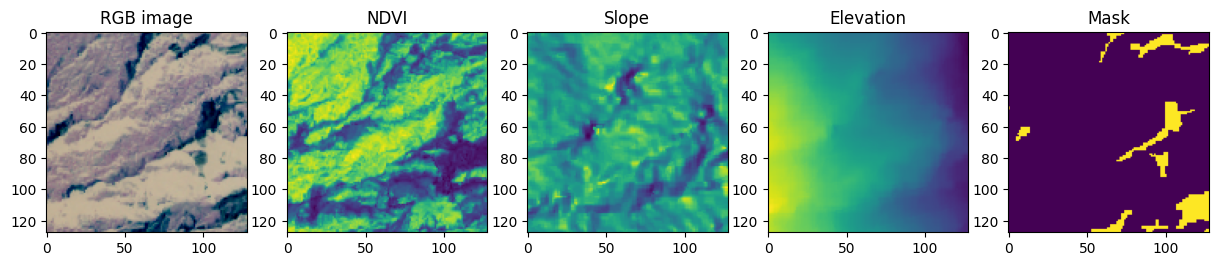

In [ ]:
img=234
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0])

Train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

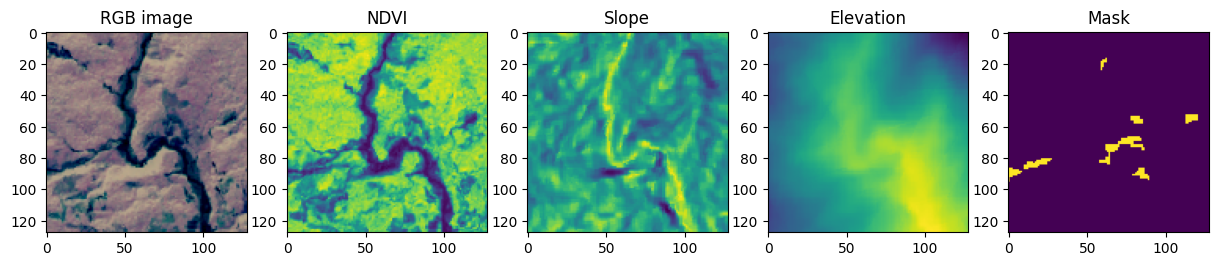

In [ ]:
img=28
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

In [ ]:
x_train.shape, y_train.shape

((3039, 128, 128, 6), (3039, 128, 128, 1))

Metric Initializer

In [ ]:
# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision*recall) / (precision+recall + K.epsilon()))

# Training Progress

In [ ]:
def conv_block(input_tensor, num_filters, dropout_rate=0.0):
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(input_tensor, num_filters, dropout_rate=0.0):
    x = conv_block(input_tensor, num_filters, dropout_rate)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_tensor, num_filters, dropout_rate=0.0):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, skip_tensor])
    x = conv_block(x, num_filters, dropout_rate)
    return x

In [ ]:
def unet_model(img_width, img_height, img_channels):
    inputs = Input((img_width, img_height, img_channels))
    s = Lambda(lambda x: x / 255.0)(inputs)  # Normalize inputs

    # Encoder path
    c1, p1 = encoder_block(s, 16, dropout_rate=0.2)
    c2, p2 = encoder_block(p1, 32, dropout_rate=0.2)
    c3, p3 = encoder_block(p2, 64, dropout_rate=0.3)
    c4, p4 = encoder_block(p3, 128, dropout_rate=0.3)

    # Bottleneck
    c5 = conv_block(p4, 256, dropout_rate=0.4)

    # Decoder path
    c6 = decoder_block(c5, c4, 128, dropout_rate=0.3)
    c7 = decoder_block(c6, c3, 64, dropout_rate=0.3)
    c8 = decoder_block(c7, c2, 32, dropout_rate=0.2)
    c9 = decoder_block(c8, c1, 16, dropout_rate=0.2)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])

    return model


In [ ]:
model = unet_model(128, 128, 6)
model.summary()

Model: "functional_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_120           │ (None, 128, 128, 6)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 128, 128, 6)    │              0 │ input_layer_120[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_378 (Conv2D)       │ (None, 128, 128, 16)   │            880 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_264   │ (None, 128, 128, 16)   │             64 │ conv2d_378[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_72 (Dropout)      │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_379 (Conv2D)       │ (None, 128, 128, 16)   │          2,320 │ dropout_72[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_265   │ (None, 128, 128, 16)   │             64 │ conv2d_379[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_60          │ (None, 64, 64, 16)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_380 (Conv2D)       │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_266   │ (None, 64, 64, 32)     │            128 │ conv2d_380[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_73 (Dropout)      │ (None, 64, 64, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_381 (Conv2D)       │ (None, 64, 64, 32)     │          9,248 │ dropout_73[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_267   │ (None, 64, 64, 32)     │            128 │ conv2d_381[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_61          │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_382 (Conv2D)       │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_61[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_268   │ (None, 32, 32, 64)     │            256 │ conv2d_382[0][0]       │
│ (BatchNormalization) 

 Total params: 1,947,425 (7.43 MB)

 Trainable params: 1,944,481 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
epochs = 300
batch_size = 16

In [ ]:
model_path = "/content/drive/MyDrive/models/"
os.makedirs(model_path, exist_ok=True)  # Tạo thư mục nếu chưa có

In [ ]:
checkpointer = ModelCheckpoint(
    filepath=os.path.join(model_path, "best_model_landslide_3.keras"),
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=1,
    mode='min')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6)

callbacks = [
    earlyStopping,
    checkpointer,
    reduce_lr
    ]
history = model.fit(
          x_train, y_train,
          batch_size=batch_size,
          epochs = epochs,
          verbose = 2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

model.save(os.path.join(model_path, "final_model_landslide_3.keras"))

Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1929']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.37407, saving model to /content/drive/MyDrive/models/best_model_landslide_3.keras
190/190 - 45s - 238ms/step - accuracy: 0.8379 - f1_m: 0.2739 - loss: 0.5767 - precision_m: 0.1906 - recall_m: 0.7668 - val_accuracy: 0.9750 - val_f1_m: 0.0000e+00 - val_loss: 0.3741 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/300

Epoch 2: val_loss improved from 0.37407 to 0.22196, saving model to /content/drive/MyDrive/models/best_model_landslide_3.keras
190/190 - 3s - 17ms/step - accuracy: 0.9790 - f1_m: 0.5486 - loss: 0.3187 - precision_m: 0.5694 - recall_m: 0.5845 - val_accuracy: 0.9750 - val_f1_m: 0.0000e+00 - val_loss: 0.2220 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/300

Epoch 3: val_loss improved from 0.22196 to 0.14288, saving model to /content/drive/MyDrive/models/best_model_landslide_3.keras
190/190 - 3s - 17ms/step - accuracy: 0.9832 - f1_m: 0.5703 - los

Save model history

In [ ]:
import json

history_path = "/content/drive/MyDrive/models/final_model_history_3.json"

with open(history_path, "w") as f:
    json.dump(history.history, f)



In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

0.033637724816799164 0.9870105385780334 0.7116837501525879 0.7652752995491028 0.669338047504425


#Prediction

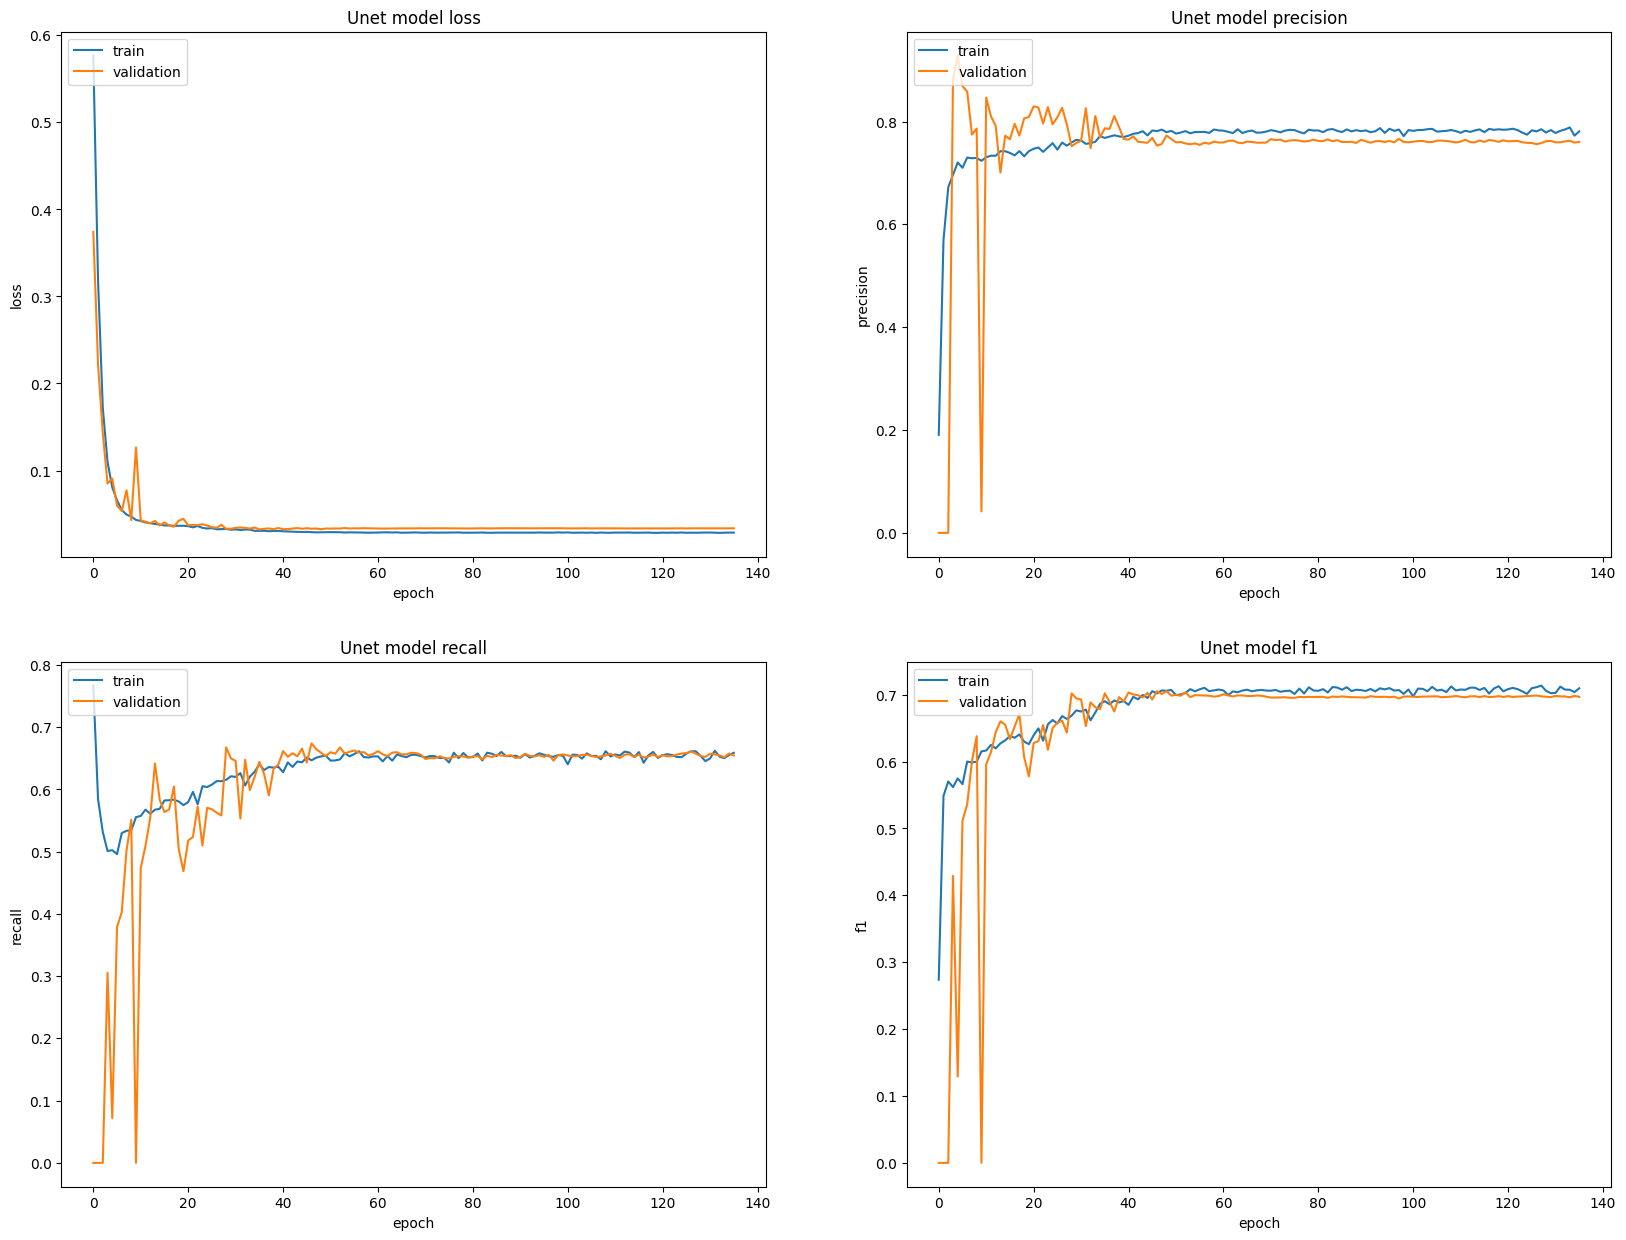

In [ ]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [ ]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1929']
Received: inputs=Tensor(shape=(32, 128, 128, 6))
  warnings.warn(msg)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step


Text(0.5, 1.0, 'Training Image')

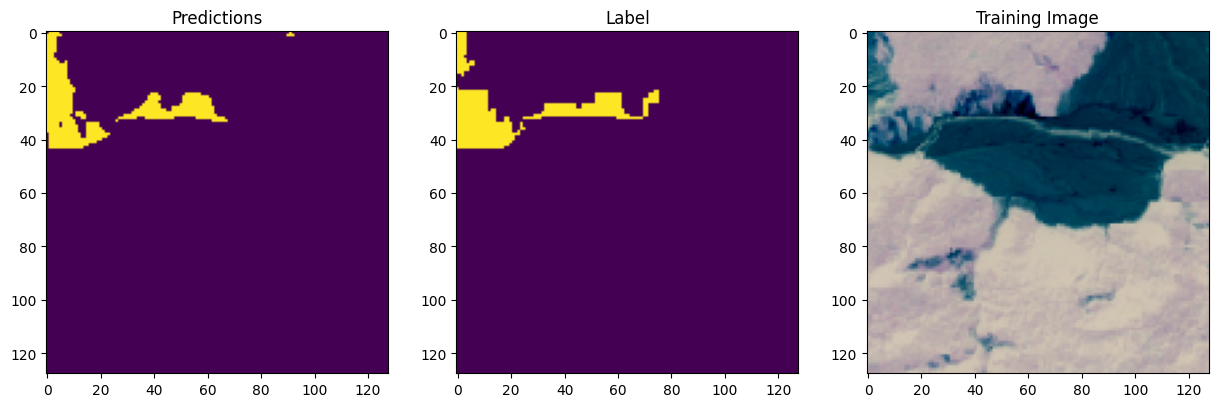

In [ ]:
img = 199
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

Load pretrained model

In [ ]:
loaded_model = tf.keras.models.load_model(
    os.path.join(model_path, "/content/drive/MyDrive/models/final_model/final_model_landslide_3.keras"),
    custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m},
    safe_mode=False
)

In [ ]:
threshold = 0.5
pred_img = loaded_model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step


Text(0.5, 1.0, 'Training Image')

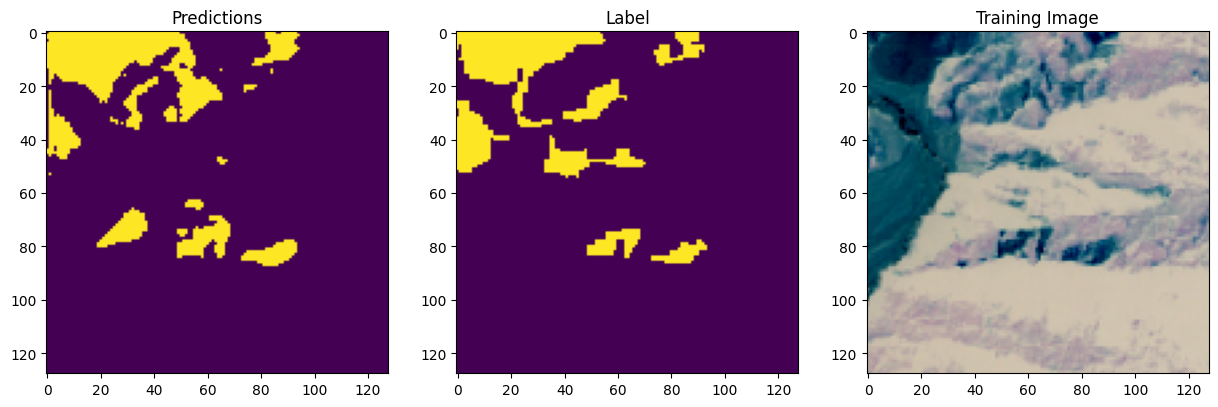

In [ ]:
img = 291
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

In [ ]:
with open(history_path, "r") as f:
    loaded_history = json.load(f)

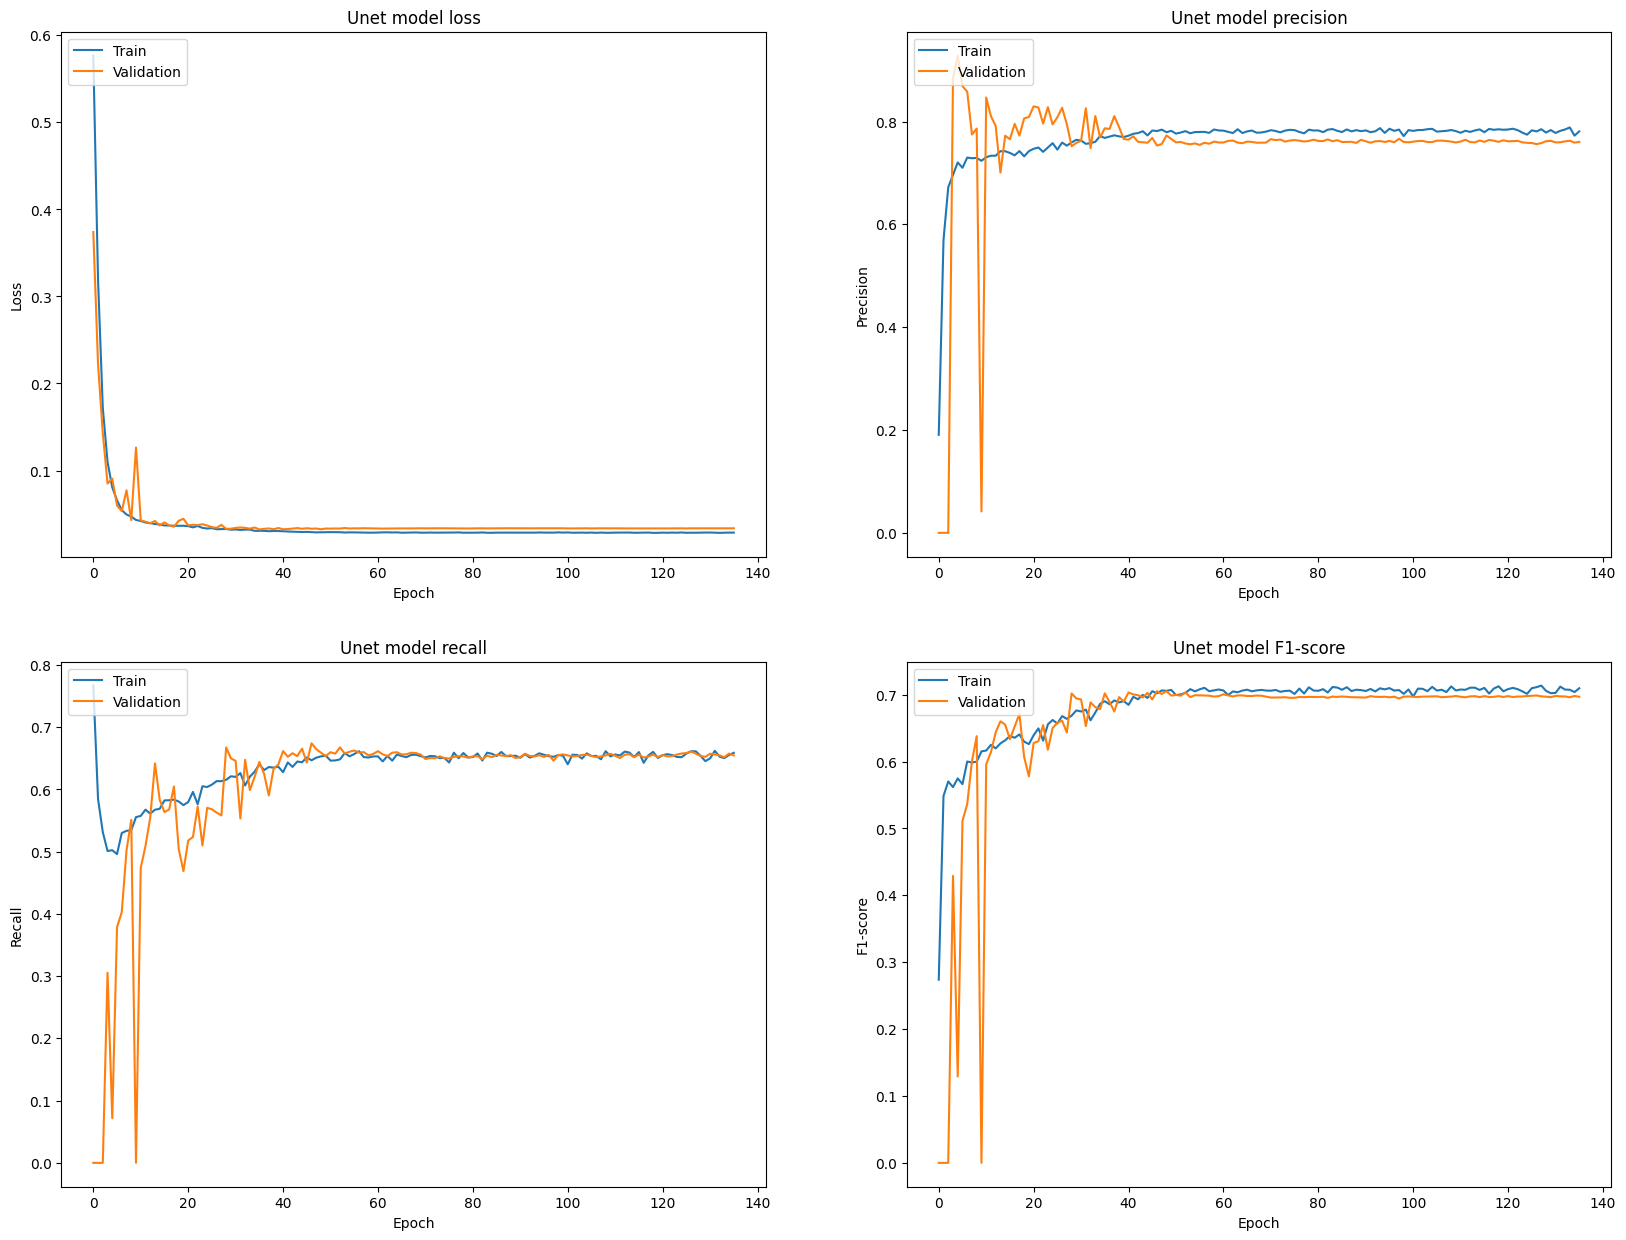

In [ ]:
import matplotlib.pyplot as plt

fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))

ax11.plot(loaded_history['loss'])
ax11.plot(loaded_history['val_loss'])
ax11.set_title('Unet model loss')
ax11.set_ylabel('Loss')
ax11.set_xlabel('Epoch')
ax11.legend(['Train', 'Validation'], loc='upper left')

ax12.plot(loaded_history['precision_m'])
ax12.plot(loaded_history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('Precision')
ax12.set_xlabel('Epoch')
ax12.legend(['Train', 'Validation'], loc='upper left')

ax13.plot(loaded_history['recall_m'])
ax13.plot(loaded_history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('Recall')
ax13.set_xlabel('Epoch')
ax13.legend(['Train', 'Validation'], loc='upper left')

ax14.plot(loaded_history['f1_m'])
ax14.plot(loaded_history['val_f1_m'])
ax14.set_title('Unet model F1-score')
ax14.set_ylabel('F1-score')
ax14.set_xlabel('Epoch')
ax14.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Masking new images

In [ ]:
valid_img_path = r'/content/drive/MyDrive/landslide_dataset/ValidData/img/*.h5'
all_valid = sorted(glob.glob(valid_img_path))

num_samples = len(all_valid)

VAL_XX = np.zeros((num_samples, 128, 128, 6))

print(f"Found {num_samples} validation images")

Found 245 validation images


In [ ]:
mask_name = []
for i, img in enumerate(all_valid):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        VAL_XX[i, :, :, 3] = data_ndvi #NDVI
        VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

0 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_1.h5
1 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_10.h5
2 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_100.h5
3 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_101.h5
4 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_102.h5
5 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_103.h5
6 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_104.h5
7 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_105.h5
8 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_106.h5
9 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_107.h5
10 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_108.h5
11 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_109.h5
12 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_11.h5
13 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_110.h5
14 /content/drive/My

<ipython-input-8-f7a20b74d9b3>:20: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


166 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_28.h5
167 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_29.h5
168 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_3.h5
169 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_30.h5
170 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_31.h5
171 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_32.h5
172 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_33.h5
173 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_34.h5
174 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_35.h5
175 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_36.h5
176 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_37.h5
177 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_38.h5
178 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_39.h5
179 /content/drive/MyDrive/landslide_dataset/ValidData/img/image_4.h5
180 /con

In [ ]:
VAL_XX[np.isnan(VAL_XX)] = 0.000001
print(VAL_XX.min(), VAL_XX.max())

-1.6689530490288487 1.0


##Prediction for validation data

In [ ]:
threshold = 0.5
pred_img = loaded_model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step


(245, 128, 128, 1)

Text(0.5, 1.0, 'Training Image')

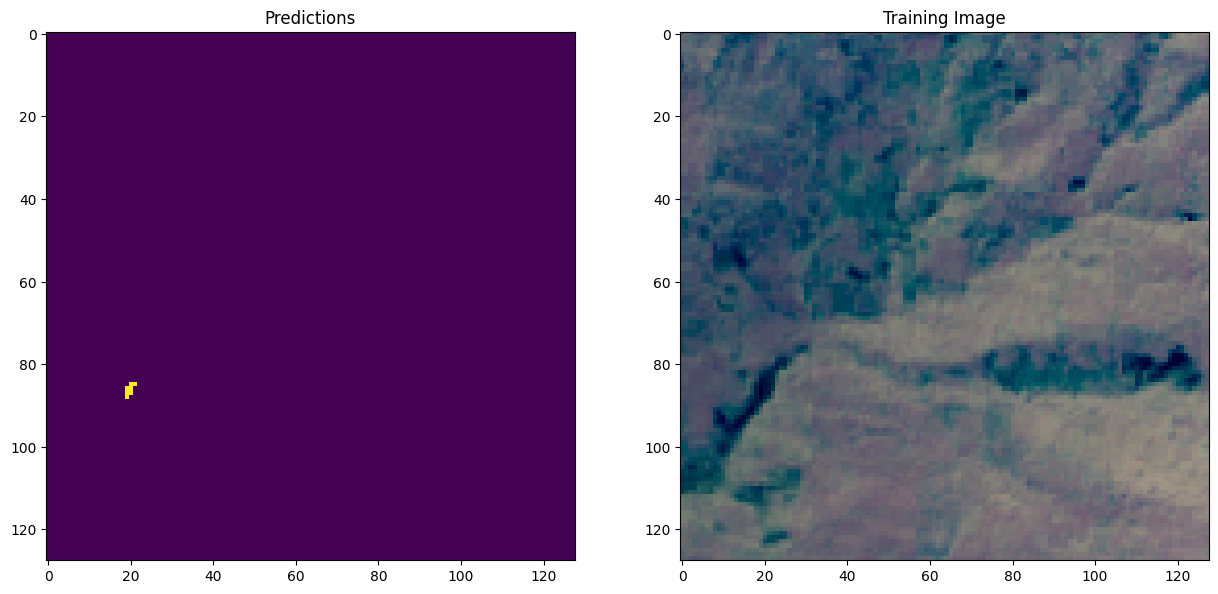

In [ ]:
img = 156
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


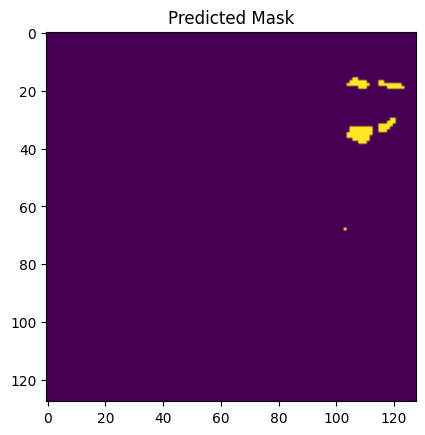

In [ ]:
# prompt: tôi muốn có thể đưa vào một ảnh .h5 mới sau đó sẽ in ra masking của hình ảnh

def predict_mask_from_h5(model, h5_path):
  """Predicts the mask for a given .h5 image file.

  Args:
    model: The trained U-Net model.
    h5_path: The path to the .h5 image file.

  Returns:
    A NumPy array representing the predicted mask.
  """

  with h5py.File(h5_path) as hdf:
      data = np.array(hdf.get('img'))

      # assign 0 for the nan value
      data[np.isnan(data)] = 0.000001

      # to normalize the data
      mid_rgb = data[:, :, 1:4].max() / 2.0
      mid_slope = data[:, :, 12].max() / 2.0
      mid_elevation = data[:, :, 13].max() / 2.0

      # ndvi calculation
      data_red = data[:, :, 3]
      data_nir = data[:, :, 7]
      data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))

      # final array
      input_data = np.zeros((1, 128, 128, 6))
      input_data[0, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # RED
      input_data[0, :, :, 1] = 1 - data[:, :, 2] / mid_rgb  # GREEN
      input_data[0, :, :, 2] = 1 - data[:, :, 1] / mid_rgb  # BLUE
      input_data[0, :, :, 3] = data_ndvi  # NDVI
      input_data[0, :, :, 4] = 1 - data[:, :, 12] / mid_slope  # SLOPE
      input_data[0, :, :, 5] = 1 - data[:, :, 13] / mid_elevation  # ELEVATION

      input_data[np.isnan(input_data)] = 0.000001

      # Prediction
      threshold = 0.5
      prediction = model.predict(input_data)
      predicted_mask = (prediction > threshold).astype(np.uint8)

      return predicted_mask[0, :, :, 0]


# Example usage:
new_h5_image_path = '/content/drive/MyDrive/landslide_dataset/TrainData/img/image_1.h5'  # Replace with the path to your new .h5 file

predicted_mask = predict_mask_from_h5(loaded_model, new_h5_image_path)

# Display the predicted mask
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.show()


In [ ]:
write_directory = r'/content/drive/MyDrive/landslide_dataset/ValidData/mask'
os.makedirs(write_directory, exist_ok=True)
for i, name in enumerate(mask_name):
  h5f = h5py.File(write_directory + "/" + name, 'w')
  # change the dimention of prediction to (n, 128, 128)
  pred_mask = pred_img[i, :, :, 0]

  # write to the directory
  h5f.create_dataset('mask', data = pred_mask)
  h5f.close()

In [ ]:
import os
import h5py
import numpy as np
from PIL import Image

def convert_h5_to_images(input_folder, output_folder, image_format="JPEG"):
    """
    Duyệt qua tất cả file .h5 trong thư mục `input_folder` và lưu ảnh vào `output_folder`

    Parameters:
    - input_folder (str): Đường dẫn thư mục chứa các file .h5
    - output_folder (str): Đường dẫn thư mục để lưu ảnh đầu ra
    - image_format (str): Định dạng ảnh đầu ra, mặc định là "JPEG"
    """
    os.makedirs(output_folder, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

    # Duyệt qua tất cả file .h5 trong thư mục
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".h5"):
            h5_path = os.path.join(input_folder, file_name)

            try:
                with h5py.File(h5_path, 'r') as hdf:
                    # Lấy danh sách các dataset trong file
                    datasets = list(hdf.keys())

                    for dataset_name in datasets:
                        array = np.array(hdf[dataset_name])

                        # Nếu dữ liệu có nhiều ảnh, duyệt qua từng ảnh
                        if len(array.shape) == 4:  # (batch, height, width, channels)
                            for i in range(array.shape[0]):
                                img = Image.fromarray(array[i].astype('uint8'), 'RGB')
                                img.save(os.path.join(output_folder, f"{file_name}_{dataset_name}_{i}.{image_format.lower()}"), image_format)

                        else:  # Trường hợp chỉ có một ảnh
                            img = Image.fromarray(array.astype('uint8'), 'RGB')
                            img.save(os.path.join(output_folder, f"{file_name}_{dataset_name}.{image_format.lower()}"), image_format)

                print(f"✔ Chuyển đổi thành công: {file_name}")
            except Exception as e:
                print(f"❌ Lỗi khi xử lý {file_name}: {e}")

# ======================== DEMO ========================
input_folder = "/content/drive/MyDrive/landslide_dataset/ValidData/img"  # Thư mục chứa các file .h5
output_folder = "/content/drive/MyDrive/landslide_dataset/ConvertedData"  # Thư mục để lưu ảnh JPG

convert_h5_to_images(input_folder, output_folder, image_format="JPEG")


✔ Chuyển đổi thành công: image_1.h5
✔ Chuyển đổi thành công: image_10.h5
✔ Chuyển đổi thành công: image_100.h5
✔ Chuyển đổi thành công: image_101.h5
✔ Chuyển đổi thành công: image_102.h5
✔ Chuyển đổi thành công: image_103.h5
✔ Chuyển đổi thành công: image_104.h5
✔ Chuyển đổi thành công: image_105.h5
✔ Chuyển đổi thành công: image_106.h5
✔ Chuyển đổi thành công: image_107.h5
✔ Chuyển đổi thành công: image_108.h5
✔ Chuyển đổi thành công: image_109.h5
✔ Chuyển đổi thành công: image_11.h5
✔ Chuyển đổi thành công: image_110.h5
✔ Chuyển đổi thành công: image_111.h5
✔ Chuyển đổi thành công: image_112.h5
✔ Chuyển đổi thành công: image_113.h5
✔ Chuyển đổi thành công: image_114.h5
✔ Chuyển đổi thành công: image_115.h5
✔ Chuyển đổi thành công: image_116.h5
✔ Chuyển đổi thành công: image_117.h5
✔ Chuyển đổi thành công: image_118.h5
✔ Chuyển đổi thành công: image_119.h5
✔ Chuyển đổi thành công: image_12.h5
✔ Chuyển đổi thành công: image_120.h5
✔ Chuyển đổi thành công: image_121.h5
✔ Chuyển đổi thàn